### cbg data analysis - python rewrite

In [1]:
import numpy as np
import pandas as pd
import glob
import xgboost as xgb

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

In [2]:
dataset = 'huge'
days_n = 21
minimum_n_cbgs = days_n + 2

hypothreshold = 3

In [3]:
load_path = "/media/psf/Home/Documents/data/CBGdata"
rowLimit = None

df = pd.read_csv(f"{load_path}/{dataset}_unipoc_time_series_cohort_first_{days_n}_days.csv",
                     nrows = rowLimit, header = 0)

In [4]:
# exclude rows based on location
pre_removal_rows = df.shape[0]
exclude_vector = ['dialysis', 'Dialysis Centre - Level 2','renal',
                  'abbott', 'Ketones', 'Lab point of care room -IN',
                  'ARU2 Ketones', 'ED Ketones', 'REndoscopy Unit',
                  'LAB - Sent back to Abbott', 'Biochemistryx',
                  'Renal G6 Dialysis', 'Wd 5B Ketones', 'AAU Ketones',
                  'Dead meters', 'Lab Study room back to abbott',
                  'Health at Heart', 'A&E Ketones', 'IAU Ketones',
                  'MAU Office (Ketone)', 'OLD PXP Meters', 'Wd 6D Ketones',
                  'BIO POOL meters', 'OBSOLETE METERS 2', 'Meterx not found',
                  'X Ray', 'X-ray', 'training', 'staff', 'MAU (Ketone)',
                  'more dead meters',
                  'LOST IN DRUM', 'Labour Suite',
                  'returned', 'obsolete', 'old', 'Meterx',
                  'dead', 'BioChemistry', 'weldon', 'Pre Ass clinic Gen OP',
                  'radiology', 'outpatient', 'rcas', 'Meter not found', 'spare meters',
                  'Labour Ward', 'Neonatal Unit Top Floor']
df = df[~df['loc'].isin(exclude_vector)]
post_removal_rows = df.shape[0]

# df['loc'].unique() ## show all loc values

print(f'{pre_removal_rows - post_removal_rows} rows removed on loc')

id_pre_removal_rows = df.shape[0]
id_exclude_vector = [222222222222222]

df = df[~df['uID'].isin(id_exclude_vector)]
id_post_removal_rows = df.shape[0]

print(f'{id_pre_removal_rows - id_post_removal_rows} rows removed on uID')

40217 rows removed on loc
21 rows removed on uID


In [5]:
# add unique ID by 2 cols - uID and admission vec
df = df.copy()
df['id_gp'] = df.groupby(['uID', 'admission_vec']).ngroup()

In [6]:
# convert to pandas datetime format and generate a day only col
df['datetimeIndex'] = pd.to_datetime(df['dateTime'], format="%Y-%m-%d %H:%M:%S")
df['just_date'] = df['datetimeIndex'].dt.date

In [7]:
df.groupby(['id_gp']).size()
df['min_date'] = df['just_date'].groupby(df['id_gp']).transform('min')
df['max_date'] = df['just_date'].groupby(df['id_gp']).transform('max')
df['diff_days'] = df['max_date']-df['min_date']
# convert delta days to integer
df['diff_days'] = df['diff_days'].dt.days.astype('int16')
# limit to days_n admissions
# some shorter admissions may have crept in due to the location exclusions above
df = df[df['diff_days']>=days_n]
# limit to min number cbg measurements
df = df[df['N']>=minimum_n_cbgs]

In [8]:
%matplotlib inline

<AxesSubplot: ylabel='Frequency'>

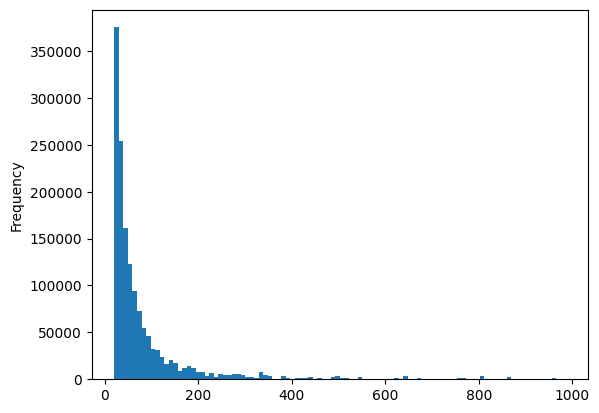

In [9]:
df['diff_days'].plot.hist(bins = 100)

In [18]:
# flag last day
df['last_day'] = np.where((df['just_date'] == df['max_date']), 1, 0)
# split into pre last day and last day frames
ltdf = df[df['last_day']==1]

In [19]:
ltdf = ltdf.copy()
ltdf['min_glu'] = ltdf['Glu'].groupby(ltdf['id_gp']).transform('min')

In [24]:
ltdf

,uID,admission_vector,datetime,Glu,loc,dateTime,unix_dateTime,n_admissions,interval_seconds,interval_days,...,new_interval_seconds,admission_vec,id_gp,datetimeIndex,just_date,min_date,max_date,diff_days,last_day,min_glu
35,101176147,8,16/03/2016 7:09AM,4.6,54,2016-03-16 07:09:00,1.458112e+09,9.0,2299920,27,...,2299920,1,0,2016-03-16 07:09:00,2016-03-16,2016-02-18,2016-03-16,27,1,4.6
92,101236085,1,08/01/2014 7:02AM,6.9,GG3C,2014-01-08 07:02:00,1.389165e+09,4.0,2875260,33,...,2875260,1,1,2014-01-08 07:02:00,2014-01-08,2013-12-06,2014-01-08,33,1,6.9
167,101236085,2,07/03/2014 6:31AM,5.3,GG3A,2014-03-07 06:31:00,1.394174e+09,4.0,1936380,23,...,1936380,2,2,2014-03-07 06:31:00,2014-03-07,2014-02-12,2014-03-07,23,1,5.3
247,101236085,3,03/07/2014 7:12AM,5.8,GG3C,2014-07-03 07:12:00,1.404368e+09,4.0,2146140,25,...,2146140,3,3,2014-07-03 07:12:00,2014-07-03,2014-06-08,2014-07-03,25,1,5.8
248,101236085,3,03/07/2014 4:53PM,9.2,GG3C,2014-07-03 16:53:00,1.404403e+09,4.0,2146140,25,...,2146140,3,3,2014-07-03 16:53:00,2014-07-03,2014-06-08,2014-07-03,25,1,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572290,4667611667,2,29/04/2015 9:14AM,12.5,Mary Aitkenhead,2015-04-29 09:14:00,1.430295e+09,2.0,11454300,132,...,11454300,1,16247,2015-04-29 09:14:00,2015-04-29,2014-12-18,2015-04-29,132,1,11.6
1572291,4667611667,2,29/04/2015 1:03PM,11.6,Mary Aitkenhead,2015-04-29 13:03:00,1.430309e+09,2.0,11454300,132,...,11454300,1,16247,2015-04-29 13:03:00,2015-04-29,2014-12-18,2015-04-29,132,1,11.6
1572292,4667611667,2,29/04/2015 5:24PM,13.9,Mary Aitkenhead,2015-04-29 17:24:00,1.430325e+09,2.0,11454300,132,...,11454300,1,16247,2015-04-29 17:24:00,2015-04-29,2014-12-18,2015-04-29,132,1,11.6
1572293,4667611667,2,29/04/2015 10:14PM,14.2,Mary Aitkenhead,2015-04-29 22:14:00,1.430342e+09,2.0,11454300,132,...,11454300,1,16247,2015-04-29 22:14:00,2015-04-29,2014-12-18,2015-04-29,132,1,11.6


In [11]:
df['label'] = np.where((df['last_day'] == 1 & (np.min(df['Glu'].astype('float64')) < hypothreshold)), 1, 0)

In [12]:
df['Glu'] = df['Glu'].astype('float64')

In [302]:
np.where((df['last_day'] == 1 & (np.min(df['Glu'].astype('float64')) < hypothreshold)), 1, 0)

array([0, 0, 0, ..., 0, 0, 1])

In [21]:
np.where(ltdf['min_glu'] == 1, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

In [204]:
result = df.groupby('id_gp')['just_date'].agg(['max','min'])
result['diff'] = result['max']-result['min']
print(result[['diff']])

         diff
id_gp        
0     27 days
1     33 days
2     23 days
3     25 days
4     46 days
...       ...
971   44 days
972   22 days
973   35 days
974   48 days
975    3 days

[976 rows x 1 columns]


In [223]:
df

,uID,admission_vector,datetime,Glu,loc,dateTime,unix_dateTime,n_admissions,interval_seconds,interval_days,...,new_interval_seconds,admission_vec,id_gp,datetimeIndex,just_date,admission_days,min_date,max_date,diff,diff_days
0,101176147,8,18/02/2016 4:17PM,10.4,Immediate Assessment Unit,2016-02-18 16:17:00,1.455812e+09,9.0,2299920,27,...,2299920,1,0,2016-02-18 16:17:00,2016-02-18,NaT,2016-02-18,2016-03-16,27 days,27
1,101176147,8,20/02/2016 6:57AM,4.9,8A,2016-02-20 06:57:00,1.455951e+09,9.0,2299920,27,...,2299920,1,0,2016-02-20 06:57:00,2016-02-20,2 days,2016-02-18,2016-03-16,27 days,27
2,101176147,8,20/02/2016 2:17PM,7.4,8A,2016-02-20 14:17:00,1.455978e+09,9.0,2299920,27,...,2299920,1,0,2016-02-20 14:17:00,2016-02-20,0 days,2016-02-18,2016-03-16,27 days,27
3,101176147,8,20/02/2016 6:50PM,9.8,8A,2016-02-20 18:50:00,1.455994e+09,9.0,2299920,27,...,2299920,1,0,2016-02-20 18:50:00,2016-02-20,0 days,2016-02-18,2016-03-16,27 days,27
4,101176147,8,20/02/2016 11:30PM,11.8,8A,2016-02-20 23:30:00,1.456011e+09,9.0,2299920,27,...,2299920,1,0,2016-02-20 23:30:00,2016-02-20,0 days,2016-02-18,2016-03-16,27 days,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,207926263,1,10/07/2014 3:58PM,2.4,Ward 25,2014-07-10 15:58:00,1.405004e+09,6.0,1991640,23,...,1991640,1,975,2014-07-10 15:58:00,2014-07-10,0 days,2014-07-08,2014-07-11,3 days,3
99996,207926263,1,10/07/2014 4:10PM,3.9,Ward 25,2014-07-10 16:10:00,1.405005e+09,6.0,1991640,23,...,1991640,1,975,2014-07-10 16:10:00,2014-07-10,0 days,2014-07-08,2014-07-11,3 days,3
99997,207926263,1,10/07/2014 4:22PM,5.7,Ward 25,2014-07-10 16:22:00,1.405006e+09,6.0,1991640,23,...,1991640,1,975,2014-07-10 16:22:00,2014-07-10,0 days,2014-07-08,2014-07-11,3 days,3
99998,207926263,1,10/07/2014 5:35PM,11.6,Ward 1,2014-07-10 17:35:00,1.405010e+09,6.0,1991640,23,...,1991640,1,975,2014-07-10 17:35:00,2014-07-10,0 days,2014-07-08,2014-07-11,3 days,3


In [160]:
df['N'] = df.groupby(['id_gp']).transform('size')
df['min_glu'] = df['Glu'].groupby(df['id_gp']).transform('min')

,uID,admission_vector,datetime,Glu,loc,dateTime,unix_dateTime,n_admissions,interval_seconds,interval_days,n,N,new_interval_seconds,admission_vec,id_gp,datetimeIndex,just_date,min_glu
0,101176147,8,18/02/2016 4:17PM,10.4,Immediate Assessment Unit,2016-02-18 16:17:00,1.455812e+09,9.0,2299920,27,1,36,2299920,1,0,2016-02-18 16:17:00,2016-02-18,3.8
1,101176147,8,20/02/2016 6:57AM,4.9,8A,2016-02-20 06:57:00,1.455951e+09,9.0,2299920,27,2,36,2299920,1,0,2016-02-20 06:57:00,2016-02-20,3.8
2,101176147,8,20/02/2016 2:17PM,7.4,8A,2016-02-20 14:17:00,1.455978e+09,9.0,2299920,27,3,36,2299920,1,0,2016-02-20 14:17:00,2016-02-20,3.8
3,101176147,8,20/02/2016 6:50PM,9.8,8A,2016-02-20 18:50:00,1.455994e+09,9.0,2299920,27,4,36,2299920,1,0,2016-02-20 18:50:00,2016-02-20,3.8
4,101176147,8,20/02/2016 11:30PM,11.8,8A,2016-02-20 23:30:00,1.456011e+09,9.0,2299920,27,5,36,2299920,1,0,2016-02-20 23:30:00,2016-02-20,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,407416145,1,10/04/2013 11:50AM,9.2,Ward 64,2013-04-10 11:50:00,1.365591e+09,3.0,1958640,23,98,102,1958640,1,2027,2013-10-04 11:50:00,2013-10-04,2.3
199996,407416145,1,11/04/2013 4:11PM,7.4,Ward 64,2013-04-11 16:11:00,1.365693e+09,3.0,1958640,23,99,102,1958640,1,2027,2013-11-04 16:11:00,2013-11-04,2.3
199997,407416145,1,11/04/2013 9:18PM,11.8,Ward 64,2013-04-11 21:18:00,1.365711e+09,3.0,1958640,23,100,102,1958640,1,2027,2013-11-04 21:18:00,2013-11-04,2.3
199998,407416145,1,12/04/2013 6:57AM,5.9,Ward 64,2013-04-12 06:57:00,1.365746e+09,3.0,1958640,23,101,102,1958640,1,2027,2013-12-04 06:57:00,2013-12-04,2.3


In [163]:
df['just_date'].groupby(df['id_gp']).transform('size')

0          36
1          36
2          36
3          36
4          36
         ... 
199995    102
199996    102
199997    102
199998    102
199999    102
Name: just_date, Length: 195661, dtype: int64